In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [2]:
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


In [4]:
with open("../input/testdataset/TestDataSet/labels_list.json", "r") as f:
    label_map = json.load(f)

# Create local-to-ImageNet index mapping
local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

# Dataset and model (assuming plain_transforms is already defined)
dataset_path = "../input/testdataset/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1').eval().cuda()

In [5]:
top1_correct = 0
top5_correct = 0
total = 0

resnet34.eval().cuda()

with torch.no_grad():
    for inputs, targets in tqdm(dataloader):
        inputs = inputs.cuda()
        outputs = resnet34(inputs)
        _, top5_preds = outputs.topk(5, dim=1)
        top1_preds = top5_preds[:, 0]

        # Map targets to ImageNet indices
        imagenet_targets = torch.tensor([
            local_to_imagenet[int(t)] for t in targets
        ]).to(inputs.device)

        top1_correct += (top1_preds == imagenet_targets).sum().item()
        top5_correct += sum([
            imagenet_targets[i].item() in top5_preds[i] for i in range(len(imagenet_targets))
        ])
        total += targets.size(0)

print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")

100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


In [6]:
epsilon = 0.02

mean_norms = torch.tensor([0.485, 0.456, 0.406]).cuda().view(3, 1, 1)
std_norms = torch.tensor([0.229, 0.224, 0.225]).cuda().view(3, 1, 1)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset_path = "../input/testdataset/TestDataSet"
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Load labels
with open(f"{dataset_path}/labels_list.json", "r") as f:
    label_map = json.load(f)

local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

output_dir = "./AdversarialTestSet1"
os.makedirs(output_dir, exist_ok=True)

vis_images = []


In [7]:
top1_correct = 0
top5_correct = 0
total = 0

for idx, (img, target) in enumerate(tqdm(dataloader)):
    img = img.cuda().requires_grad_(True)
    label = torch.tensor([local_to_imagenet[target.item()]]).cuda()

    # Normalize before input
    norm_img = (img - mean_norms) / std_norms
    output = resnet34(norm_img)
    loss = F.cross_entropy(output, label)
    
    resnet34.zero_grad()
    loss.backward()

    grad_sign = img.grad.data.sign()
    perturbed_img = img + epsilon * grad_sign
    perturbed_img = torch.clamp(perturbed_img, 0, 1)

    # Normalize for model input
    adv_input = (perturbed_img - mean_norms) / std_norms
    adv_output = resnet34(adv_input)
    _, top5_preds = adv_output.topk(5, dim=1)
    top1_pred = top5_preds[:, 0]

    top1_correct += (top1_pred == label).sum().item()
    top5_correct += sum([label[i].item() in top5_preds[i] for i in range(len(label))])
    total += 1

    # Save perturbed image
    adv_np = perturbed_img.squeeze().detach().cpu().numpy()
    adv_np = np.transpose(adv_np, (1, 2, 0))  # CHW → HWC
    adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
    Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

    # Collect a few failed predictions
    if len(vis_images) < 5:
        norm_orig = (img - mean_norms) / std_norms
        orig_pred = resnet34(norm_orig).argmax().item()
        adv_pred = adv_output.argmax().item()

        if orig_pred == label and adv_pred != label:
            vis_images.append((img.squeeze().cpu(), perturbed_img.squeeze().cpu(), label.item(), orig_pred, adv_pred))

100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


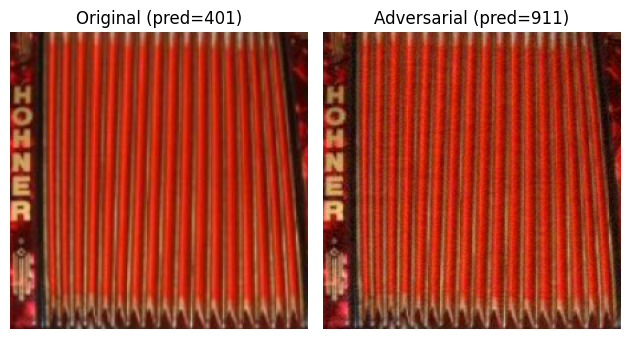

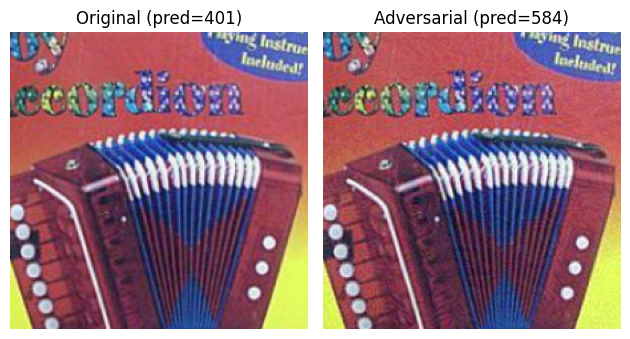

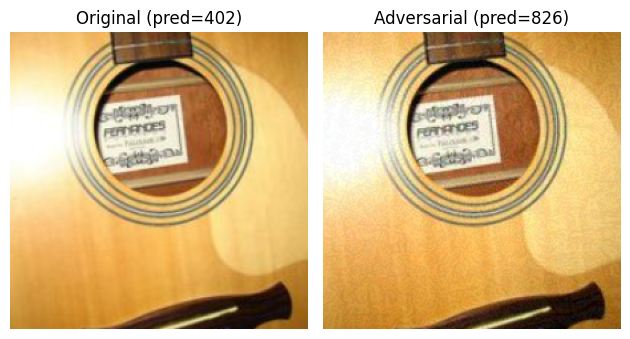

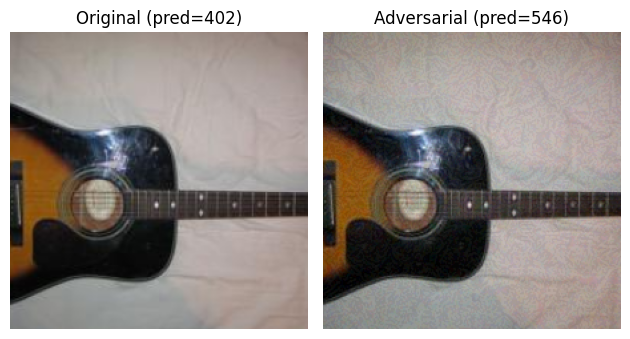

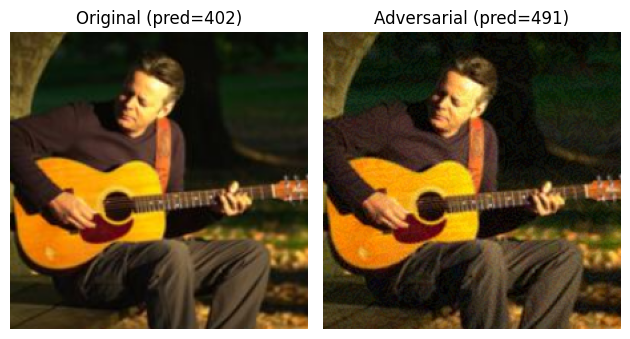

FGSM Top-1 Accuracy: 0.0300
FGSM Top-5 Accuracy: 0.1900


In [8]:
for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(orig.detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original (pred={orig_pred})")
    axes[1].imshow(np.transpose(adv.detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adversarial (pred={adv_pred})")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Final scores
print(f"FGSM Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"FGSM Top-5 Accuracy: {top5_correct / total:.4f}")

In [9]:
# PGD config
epsilon = 0.02
alpha = 0.005
num_steps = 10

# Output folder
output_dir = "./AdversarialTestSet2"
os.makedirs(output_dir, exist_ok=True)

In [10]:
for idx, (img, target) in enumerate(tqdm(dataloader)):
    orig = img.cuda()
    label = torch.tensor([local_to_imagenet[target.item()]]).cuda()

    adv = orig.clone().detach()

    for _ in range(num_steps):
        adv = adv.detach().requires_grad_(True)
        norm_adv = (adv - mean_norms) / std_norms
        output = resnet34(norm_adv)
        loss = F.cross_entropy(output, label)

        resnet34.zero_grad()
        loss.backward()

        grad = adv.grad.detach()
        adv = adv + alpha * grad.sign()
        adv = torch.max(torch.min(adv, orig + epsilon), orig - epsilon)
        adv = torch.clamp(adv, 0, 1)

    # Evaluation (wrapped in no_grad)
    with torch.no_grad():
        norm_adv = (adv - mean_norms) / std_norms
        adv_output = resnet34(norm_adv)
        _, top5_preds = adv_output.topk(5, dim=1)
        top1_pred = top5_preds[:, 0]

        top1_correct += (top1_pred == label).sum().item()
        top5_correct += sum([
            label[i].item() in top5_preds[i] for i in range(len(label))
        ])
        total += 1

        # Save image
        adv_np = adv.squeeze().cpu().numpy()
        adv_np = np.transpose(adv_np, (1, 2, 0))
        adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
        Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

        # Visualize 3–5 successful attacks
        if len(vis_images) < 5:
            norm_orig = (orig - mean_norms) / std_norms
            orig_pred = resnet34(norm_orig).argmax().item()
            adv_pred = adv_output.argmax().item()
            if orig_pred == label and adv_pred != label:
                vis_images.append((orig.squeeze().cpu(), adv.squeeze().cpu(), label.item(), orig_pred, adv_pred))


100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


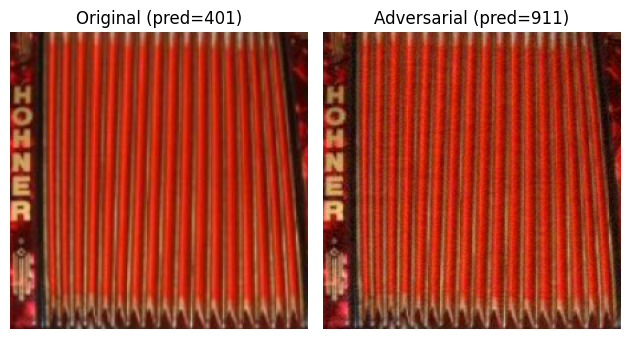

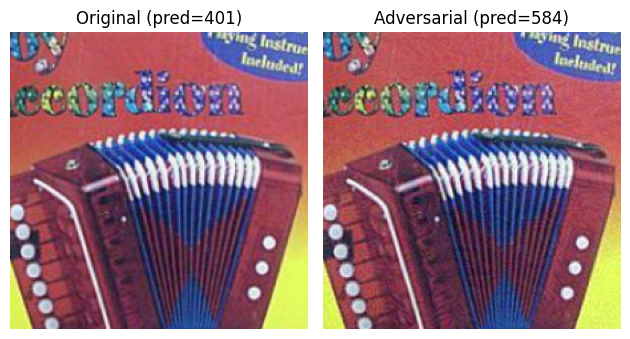

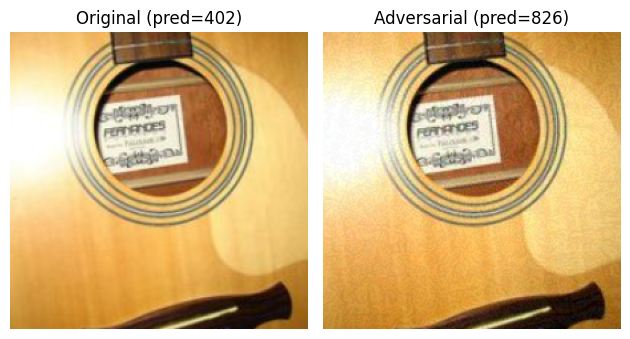

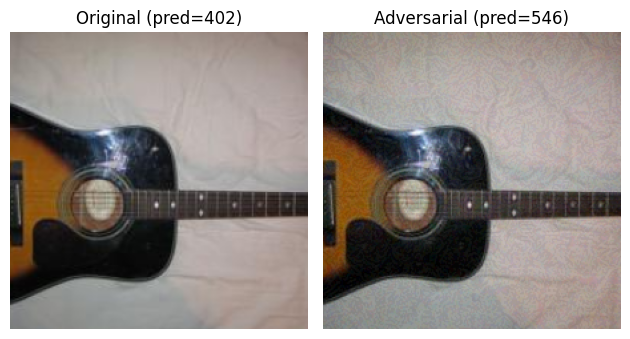

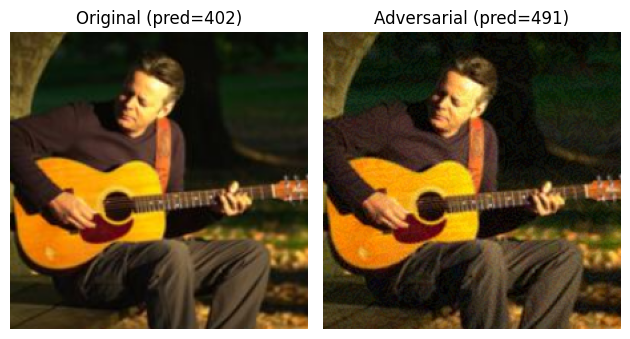

PGD Top-1 Accuracy: 0.0150
PGD Top-5 Accuracy: 0.0990


In [11]:
for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(orig.detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original (pred={orig_pred})")
    axes[1].imshow(np.transpose(adv.detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Adversarial (pred={adv_pred})")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Report final PGD attack performance
print(f"PGD Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"PGD Top-5 Accuracy: {top5_correct / total:.4f}")

In [12]:
epsilon = 0.8
alpha = 0.08
num_steps = 30
patch_size = 32

output_dir = "./AdversarialTestSet3"
os.makedirs(output_dir, exist_ok=True)

top1_correct = 0
top5_correct = 0
total = 0
vis_images = []

resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
mean_norms = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).cuda()
std_norms = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).cuda()

for idx, (img, target) in enumerate(tqdm(dataloader)):
    orig = img.cuda()
    label = target.cuda()

    adv = orig.clone().detach()

    # Centered patch
    _, _, H, W = adv.shape
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2

    # Targeted class ≠ true class
    target_class = (label + 1) % 1000

    for _ in range(num_steps):
        adv = adv.detach().requires_grad_(True)
        norm_adv = (adv - mean_norms) / std_norms
        output = resnet34(norm_adv)
        loss = F.cross_entropy(output, target_class)

        resnet34.zero_grad()
        loss.backward()

        grad = adv.grad.detach()
        patch_grad = grad[:, :, top:top+patch_size, left:left+patch_size]
        patch = adv[:, :, top:top+patch_size, left:left+patch_size]

        patch = patch + alpha * patch_grad.sign()
        patch = torch.max(torch.min(patch, orig[:, :, top:top+patch_size, left:left+patch_size] + epsilon),
                          orig[:, :, top:top+patch_size, left:left+patch_size] - epsilon)
        patch = torch.clamp(patch, 0, 1)

        adv = adv.detach()
        patched = adv.clone()
        patched[:, :, top:top+patch_size, left:left+patch_size] = patch.detach()
        adv = patched

    # Evaluate
    with torch.no_grad():
        norm_adv = (adv - mean_norms) / std_norms
        adv_output = resnet34(norm_adv)
        _, top5_preds = adv_output.topk(5, dim=1)
        top1_pred = top5_preds[:, 0]

        top1_correct += (top1_pred == label).sum().item()
        top5_correct += sum([
            label[i].item() in top5_preds[i] for i in range(len(label))
        ])
        total += 1

        # Save perturbed image
        adv_np = adv.squeeze().cpu().numpy()
        adv_np = np.transpose(adv_np, (1, 2, 0))
        adv_np_uint8 = (adv_np * 255).clip(0, 255).astype(np.uint8)
        Image.fromarray(adv_np_uint8).save(f"{output_dir}/{idx:04d}.png")

        # Visualize a few successful attacks
        norm_orig = (orig - mean_norms) / std_norms
        orig_pred = resnet34(norm_orig).argmax().item()
        adv_pred = adv_output.argmax().item()

        if len(vis_images) < 5 and orig_pred == label and adv_pred != label:
            vis_images.append((orig.squeeze().cpu(), adv.squeeze().cpu(), label.item(), orig_pred, adv_pred))

100%|██████████| 500/500 [03:07<00:00,  2.67it/s]


In [14]:
for i, (orig, adv, label, orig_pred, adv_pred) in enumerate(vis_images):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(np.transpose(orig.detach().numpy(), (1, 2, 0)))
    axes[0].set_title(f"Original (pred={orig_pred})")
    axes[1].imshow(np.transpose(adv.detach().numpy(), (1, 2, 0)))
    axes[1].set_title(f"Patch Attack (pred={adv_pred})")
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Final results
print(f"Patch PGD Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Patch PGD Top-5 Accuracy: {top5_correct / total:.4f}")

Patch PGD Top-1 Accuracy: 0.0000
Patch PGD Top-5 Accuracy: 0.0000


In [28]:
normalize = transforms.Normalize(mean=mean_norms, std=std_norms)

# Preprocessing
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset paths
dataset_paths = {
    "Original": "/kaggle/input/testdataset/TestDataSet",
    "FGSM": "./AdversarialTestSet1",
    "Full PGD": "./AdversarialTestSet2",
    "Patch PGD": "./AdversarialTestSet3"
}

# Load DenseNet-121
model = torchvision.models.densenet121(weights='IMAGENET1K_V1').eval().cuda()

In [30]:
from torch.utils.data import Dataset

class FlatImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, labels_map=None, paths=None):
        if paths:
            self.paths = paths
        else:
            all_files = glob.glob(os.path.join(root_dir, "**", "*.*"), recursive=True)
            image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPEG", ".JPG")
            self.paths = sorted([f for f in all_files if f.lower().endswith(image_exts)])
        self.transform = transform
        self.labels_map = labels_map

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels_map[idx]
        return self.transform(img), label

In [42]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets

# Mean and std for normalization
mean_norms = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std_norms = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

normalize = transforms.Normalize(mean=mean_norms, std=std_norms)

# Preprocessing
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Dataset paths
dataset_paths = {
    "Original": "/kaggle/input/testdataset/TestDataSet",
    "FGSM": "./AdversarialTestSet1",
    "Full PGD": "./AdversarialTestSet2",
    "Patch PGD": "./AdversarialTestSet3"
}

# Load DenseNet-121
model = models.densenet121(weights='IMAGENET1K_V1').eval().cuda()

# Load ImageNet label map
with open("/kaggle/input/testdataset/TestDataSet/labels_list.json", "r") as f:
    label_map = json.load(f)

local_to_imagenet = {
    local_idx: int(entry.split(":")[0])
    for local_idx, entry in enumerate(label_map)
}

class FlatImageDataset(Dataset):
    def __init__(self, root_dir=None, transform=None, labels_map=None, paths=None):
        if paths:
            self.paths = paths
        else:
            all_files = glob(os.path.join(root_dir, "**", "*.*"), recursive=True)
            image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPEG", ".JPG")
            self.paths = sorted([f for f in all_files if f.lower().endswith(image_exts)])
        self.transform = transform
        self.labels_map = labels_map

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels_map[idx]
        return self.transform(img), label

for name, path in dataset_paths.items():
    print(f"\nEvaluating {name} on DenseNet-121")
    if name == "Original":
        dataset_folder = datasets.ImageFolder(root=path, transform=eval_transforms)
        dataloader = DataLoader(dataset_folder, batch_size=32, shuffle=False)
    
        # ✅ Use Task 1-style mapping
        true_labels = [local_to_imagenet[t] for _, t in dataset_folder.imgs]
        paths = [p for p, _ in dataset_folder.imgs]
    
        top1_correct = 0
        top5_correct = 0
        total = 0
    
        with torch.no_grad():
            for inputs, targets in tqdm(dataloader):
                inputs = inputs.cuda()
                targets = torch.tensor([local_to_imagenet[int(t)] for t in targets]).to(inputs.device)
    
                outputs = model(inputs)
                _, top5_preds = outputs.topk(5, dim=1)
                top1_preds = top5_preds[:, 0]
    
                top1_correct += (top1_preds == targets).sum().item()
                top5_correct += sum([
                    targets[i].item() in top5_preds[i] for i in range(len(targets))
                ])
                total += targets.size(0)

    else:
        image_paths = sorted(glob(os.path.join(path, "*.png")))
    
        # Get true ImageNet labels from the original dataset using Task 1 method
        original_dataset = datasets.ImageFolder(root=dataset_paths["Original"], transform=eval_transforms)
        true_labels = [local_to_imagenet[t] for _, t in original_dataset.imgs]
    
        # Apply same labels to adversarial dataset
        dataset = FlatImageDataset(paths=image_paths, transform=eval_transforms, labels_map=true_labels)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        top1_correct = 0
        top5_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in tqdm(dataloader):
                inputs = inputs.cuda()
                targets = torch.tensor(targets).to(inputs.device)

                outputs = model(inputs)
                _, top5_preds = outputs.topk(5, dim=1)
                top1_preds = top5_preds[:, 0]

                top1_correct += (top1_preds == targets).sum().item()
                top5_correct += sum([
                    targets[i].item() in top5_preds[i] for i in range(len(targets))
                ])
                total += targets.size(0)

    print(f"{name} Accuracy:")
    print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
    print(f"Top-5 Accuracy: {top5_correct / total:.4f}")



Evaluating Original on DenseNet-121


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


Original Accuracy:
Top-1 Accuracy: 0.7480
Top-5 Accuracy: 0.9360

Evaluating FGSM on DenseNet-121


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_35/523151471.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).to(inputs.device)
100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


FGSM Accuracy:
Top-1 Accuracy: 0.3920
Top-5 Accuracy: 0.6780

Evaluating Full PGD on DenseNet-121


100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Full PGD Accuracy:
Top-1 Accuracy: 0.3240
Top-5 Accuracy: 0.6780

Evaluating Patch PGD on DenseNet-121


100%|██████████| 16/16 [00:02<00:00,  5.68it/s]

Patch PGD Accuracy:
Top-1 Accuracy: 0.6980
Top-5 Accuracy: 0.8960
